In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [2]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes'] 

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

from scipy.optimize import lsq_linear
def unmixing(features, cell, n_feature):
    b = features['ave_intensity'].loc[cell][: n_feature] 
    wls = features['wavelengths'].loc[cell][: n_feature]

    A = np.empty((len(b), len(mols)))
    for wl in wls:
        for i, mol in enumerate(mols):
            j = [j for j, col in enumerate(dfs[mol].columns[:-1]) 
                 if (dfs[mol].columns[j] <= wl[0] < dfs[mol].columns[j+1])][0]
            if wl[0] - dfs[mol].columns[j] > dfs[mol].columns[j + 1]- wl[0]:
                j += 1
            ex = dfs[mol].columns[j]

            k = [k for k, idx in enumerate(dfs[mol].index[:-1]) 
                 if (dfs[mol].index[k] > wl[1] >= dfs[mol].index[k+1])][0]
            if dfs[mol].index[k] - wl[1] < wl[1] - dfs[mol].index[k + 1]:
                k += 1
            em = dfs[mol].index[k]

            A[wls.index(wl), i] = dfs[mol].at[em, ex]
    res = lsq_linear(A, b, bounds=(0, np.inf), method='trf')

    return res

In [3]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/unmixing_gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


## unmixing

In [4]:
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H']

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/matrix_data_range/'
dfs = {name: pd.read_csv(fdn + name.replace(' ', '_') + '.tsv', sep='\t', index_col=0) for name in mols}

for mol in mols:
    dfs[mol].index = dfs[mol].index.astype('float')
    dfs[mol].columns = dfs[mol].columns.astype('float')

In [17]:
n_feature = 7
cell = 'C3_S1'
# b = features['ave_intensity'].loc[cell][: n_feature] 
wls = features['wavelengths'].loc[cell][: n_feature]


A = np.empty((n_feature, len(mols)))
for wl in wls:
    for i, mol in enumerate(mols):
        j = [j for j, col in enumerate(dfs[mol].columns[:-1]) 
             if (dfs[mol].columns[j] <= wl[0] < dfs[mol].columns[j+1])][0]
        if wl[0] - dfs[mol].columns[j] > dfs[mol].columns[j + 1]- wl[0]:
            j += 1
        ex = dfs[mol].columns[j]

        k = [k for k, idx in enumerate(dfs[mol].index[:-1]) 
             if (dfs[mol].index[k] > wl[1] >= dfs[mol].index[k+1])][0]
        if dfs[mol].index[k] - wl[1] < wl[1] - dfs[mol].index[k + 1]:
            k += 1
        em = dfs[mol].index[k]

        A[wls.index(wl), i] = dfs[mol].at[em, ex]

In [28]:
def make_cell(frac_bound):
    return A[:, 0] * (1 - frac_bound) + A[:, 1] * frac_bound

abundance = pd.DataFrame([], columns=mols)
features = adata.obs.copy()
for frac_bound in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    featuresi = features.iloc[[0]].copy()
    featuresi.index = ['0']
    artificial_cell_int = make_cell(frac_bound)
    artificial_cell_int *= np.random.normal(loc=1.0, scale=0.2)
    featuresi.loc['0', 'ave_intensity'][:n_feature] = list(artificial_cell_int)
    abundance.loc[frac_bound] = unmixing(featuresi, '0', n_feature)['x']
abundance

,Free NAD(P)H,Protein bound NAD(P)H
0.1,1.145533,0.127281
0.2,1.028142,0.257035
0.3,0.772873,0.331231
0.4,0.439809,0.293206
0.5,0.534414,0.534414
0.6,0.511926,0.767888
0.7,0.303539,0.708257
0.8,0.188237,0.752950
0.9,0.062629,0.563659


In [30]:
pd.DataFrame(A, columns=mols, index=wls[:n_feature])

,Free NAD(P)H,Protein bound NAD(P)H
"(325, 414)",0.081373,0.224633
"(343, 414)",0.112670,0.311030
"(370, 414)",0.086188,0.237925
"(343, 451)",0.629629,0.962841
"(370, 451)",0.481639,0.736532
"(373, 451)",0.417062,0.637779
"(343, 575)",0.000000,0.000000


In [31]:

abundance = pd.DataFrame([], columns=mols)
features = adata.obs.copy()
for cell in features.index:
    abundance.loc[cell] = unmixing(features, cell, n_feature)['x']
#abundance.to_csv(save_figures + 'NADH_abundance.tsv', sep='\t')

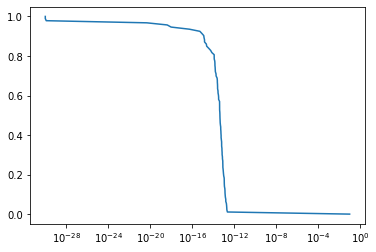

In [41]:
x = np.sort((abundance.T / abundance.sum(axis=1)).T.iloc[:, 0].values)
y = 1.0 - np.linspace(0, 1, len(x))
fig, ax = plt.subplots()
ax.plot(x + 1e-30, y)
ax.set_xscale('log')

In [50]:
def print_info_mixing(ch1, ch2):
    artificial_cell_int = make_cell(0.5)
    ratio = artificial_cell_int[ch1-1] / artificial_cell_int[ch2-1]
    print('artificial cell (50%-50%) ratio:')
    print(ratio)
    ratios = []
    for cell in features.index:
        avgint = features.loc[cell, 'ave_intensity']
        ratio = avgint[ch1-1] / avgint[ch2-1]
        ratios.append(ratio)
    print(f'real ratios of channel {ch1} to {ch2}:')
    print(ratios)
    
print_info_mixing(5, 3)

artificial cell (50%-50%) ratio:
3.7584802074028936
real ratios of channel 5 to 3:
[3.192096645861139, 0.22415642764765673, 0.4177890317115307, 0.4875161915399722, 0.639363146354037, 0.37316855646471486, 0.5194346757948517, 0.42801847453839675, 0.28502758942147777, 0.512721213730834, 0.22591464891648128, 0.2637019674378731, 0.33733071009203486, 0.2706082495440876, 0.3175371178122884, 0.3513083233627596, 0.23173545317403202, 0.20835766217535398, 0.37488771942974014, 0.3826025227053552, 0.4731393045584459, 0.5522000045404045, 0.5061968425105533, 0.40998039666793135, 0.5410282978144275, 0.24288952181157286, 0.4946106122901199, 0.5899194808995673, 0.2275884466704781, 0.4242333209185178, 0.31030754888996026, 0.2816462834561954, 0.6422446819097731, 0.4202481279546947, 0.4274639402314483, 0.6070445262790365, 0.5147673372306845, 0.3987325661324866, 0.55771972613994, 0.17769663590755708, 0.17913669326907905, 0.49106029784010696, 0.5331190477648905, 0.8411108818012842, 0.4311955484806312, 0.2278

In [5]:
n_feature = 7
abundance = pd.DataFrame([], columns=mols)
features = adata.obs.copy()
# for cell in features.index:
#     abundance.loc[cell] = unmixing(features, cell, n_feature)['x']
# abundance.to_csv(save_figures + 'NADH_abundance.tsv', sep='\t')

In [12]:
features_fake = features.copy().loc[['C3_S1']]

In [13]:
features_fake

,R1,R2,batch,grid,mask_name,#cells,picking_order,#feature,doublets,area,length,width,eccentricity,wavelengths,spectra,total_intensity,ave_intensity
cell_name,,,,,,,,,,,,,,,,,
C3_S1,C3_S1_R1_001.fastq.gz,C3_S1_R2_001.fastq.gz,1-1,dish1_M13,dish1_M13_C1,1.0,3.0,7,No,31037,215,190,1.131579,"[(325, 414), (343, 414), (370, 414), (343, 451...","[102307864, 208974856, 418306866, 108431125, 1...","[41042183.28927275, 109815935.26835814, 224365...","[1322.36309209243, 3538.2264802770287, 7228.96..."


#### abundance scatter

In [40]:
abundance = pd.read_csv(save_figures + 'NADH_abundance.tsv', sep='\t', index_col=0)

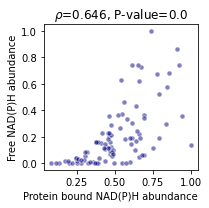

In [57]:
fig, ax = plt.subplots(figsize=[3, 3])

ax.scatter(abundance['Protein bound NAD(P)H']/abundance['Protein bound NAD(P)H'].max(), 
           abundance['Free NAD(P)H']/abundance['Free NAD(P)H'].max(), color='navy', edgecolor='white', 
           alpha=0.5, s=25)
ax.set_xlabel('Protein bound NAD(P)H abundance', loc='right')
ax.set_ylabel('Free NAD(P)H abundance')

# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.5, 0.5)

from scipy.stats import spearmanr, pearsonr
rho, p = pearsonr(abundance['Protein bound NAD(P)H'], abundance['Free NAD(P)H'])
ax.set_title(r'$\rho$={}, P-value={}'.format(str(round(rho, 3)), str(round(p, 3))))

fig.tight_layout()
fig.savefig(save_figures + 'abundance_scatter.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'abundance_scatter.png', dpi=150, bbox_inches='tight')

## correlations

In [49]:
def get_correlation(adata, feas):
    
    exp = adata.X.T
    phe = adata.obs[feas].fillna(0)

    x = exp
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [50]:
abundance = pd.read_csv(save_figures + 'NADH_abundance.tsv', sep='\t', index_col=0)
# compute the correlations between PC1, PC2 and gene expression
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
for fea in feas:
    adata.obs[fea] = abundance.loc[adata.obs_names][fea]
    
corr = get_correlation(adata, feas)
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)
corr.to_csv(save_figures + 'correlation_abundance.tsv', sep='\t')

<ipython-input-49-9aee022f18cc>:18: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T


In [6]:
corr = pd.read_csv(save_figures + 'correlation_abundance.tsv', sep='\t', index_col=0)
# # percentage of cells expressing this gene
# pct = 0.8
# gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
# high_pct = gene_pct[gene_pct >= pct].index
# corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
# corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


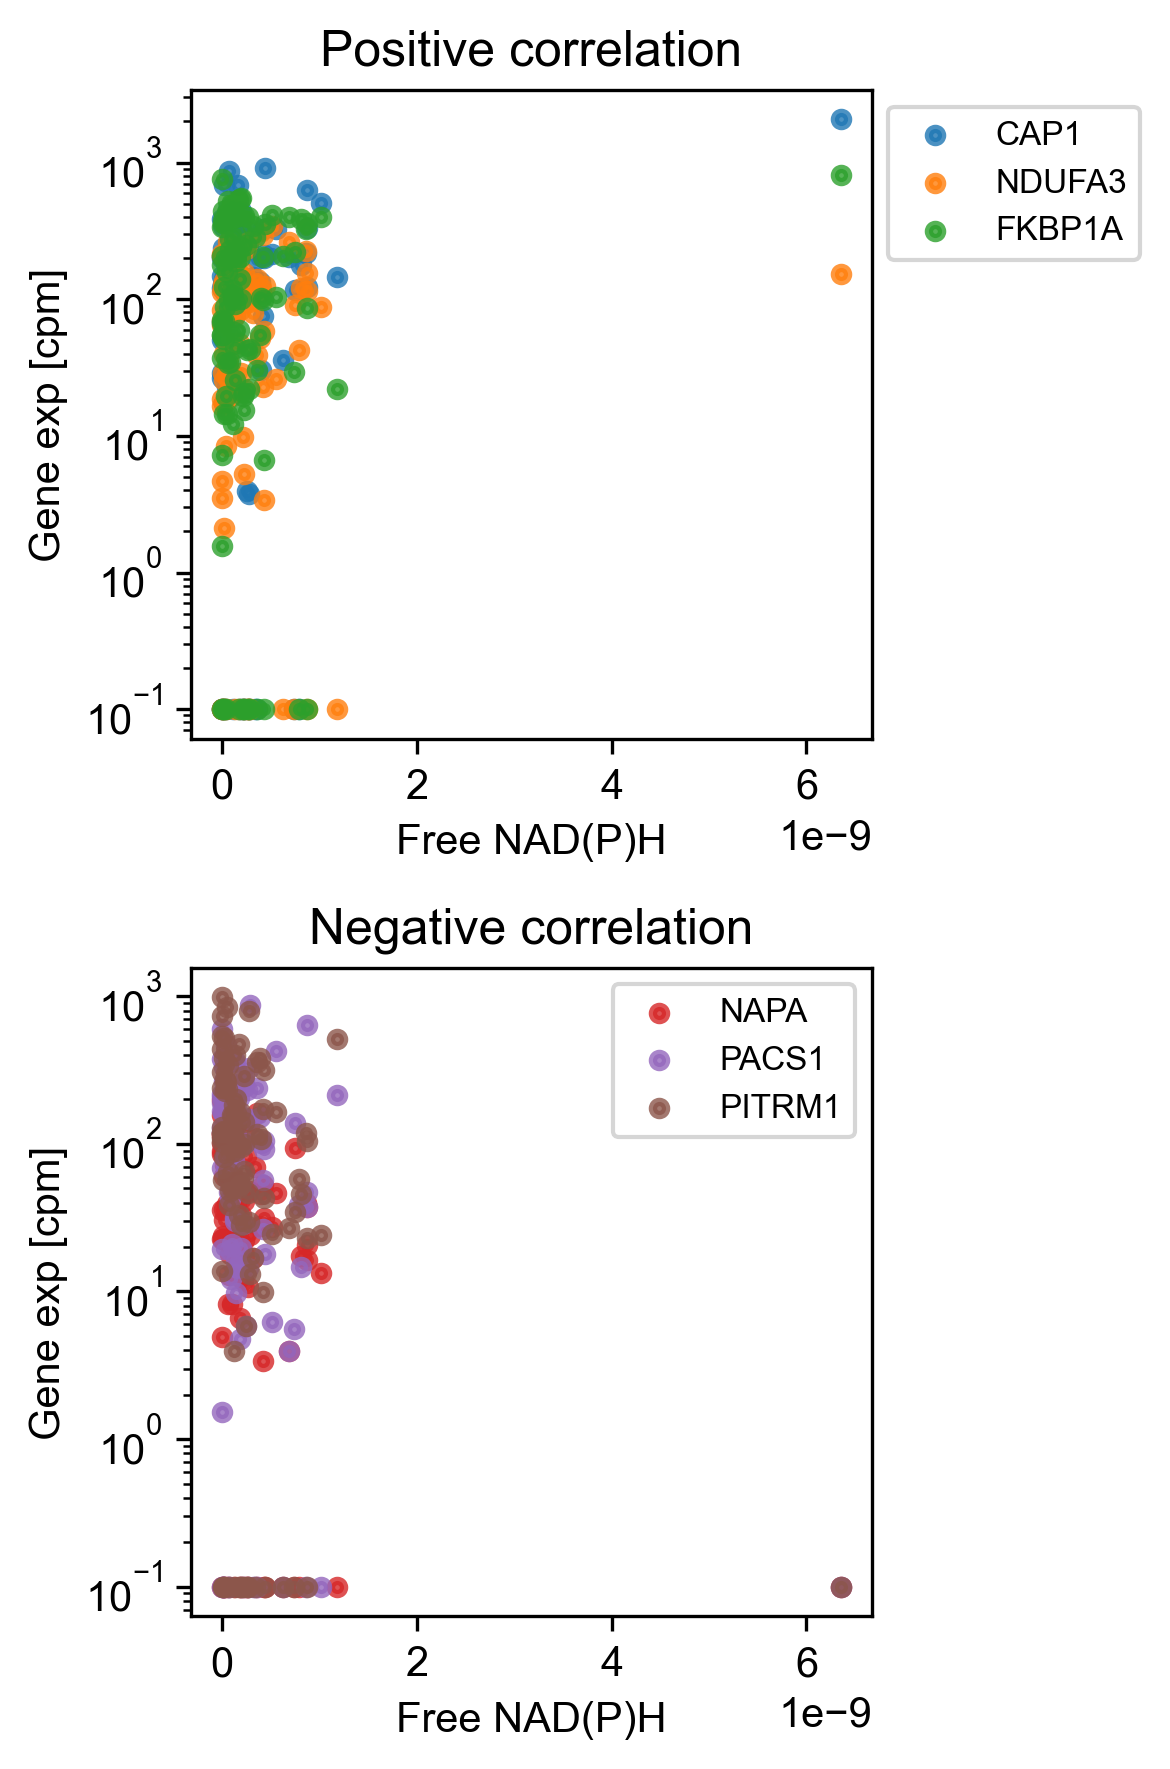

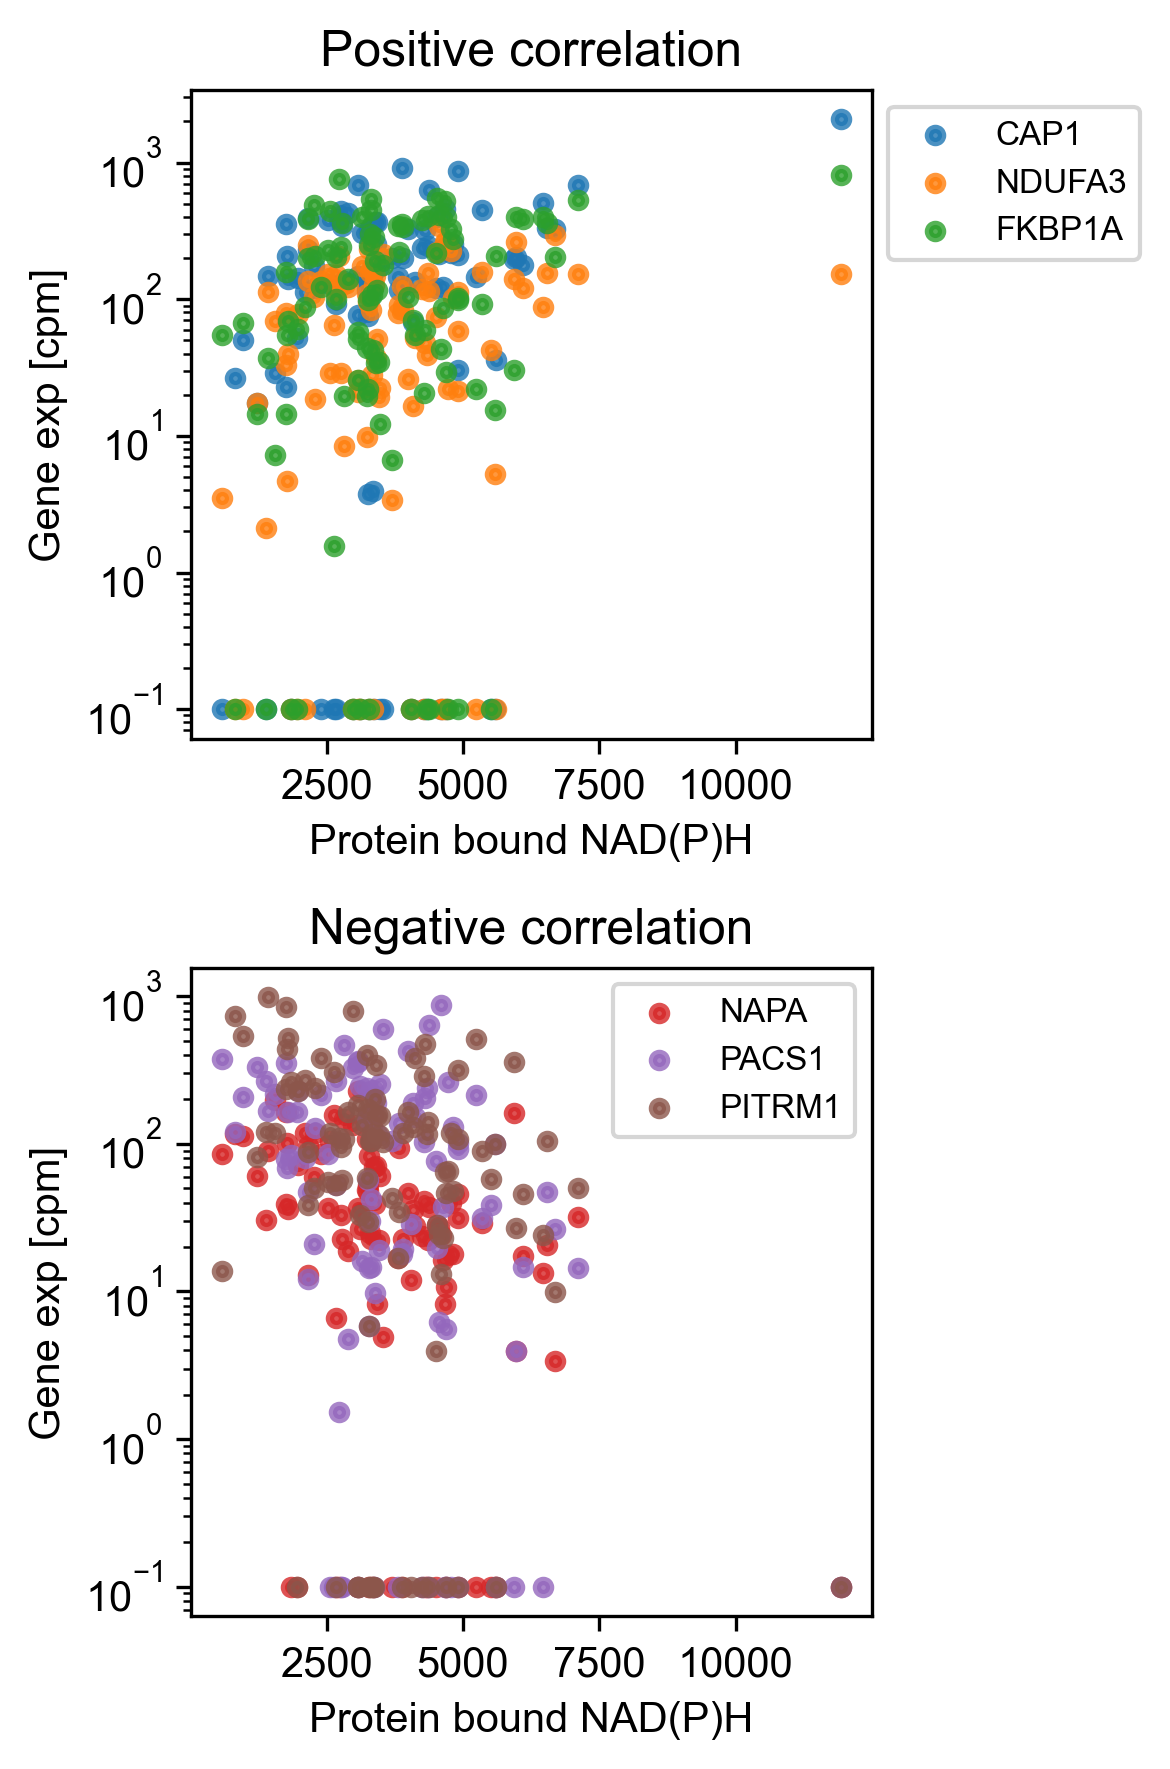

In [38]:
# plot the 3 genes with highest positive or negative correlations
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
xlabels = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea, xlabel in zip(feas, xlabels):
    pos_genes = ['CAP1', 'NDUFA3', 'FKBP1A']
#     neg_genes = corr.loc[high_pct].nsmallest(3, fea).index
    neg_genes = ['NAPA', 'PACS1', 'PITRM1']

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='1.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

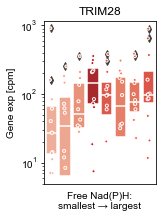

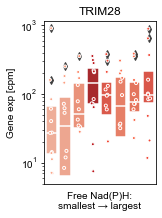

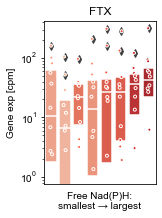

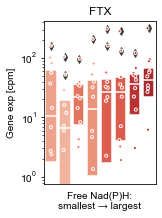

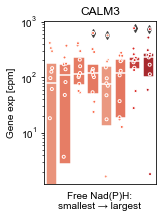

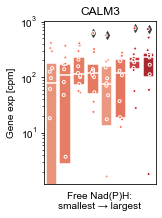

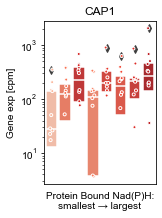

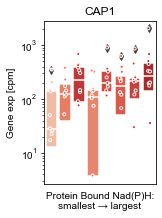

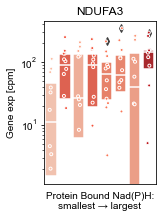

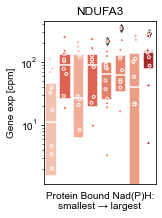

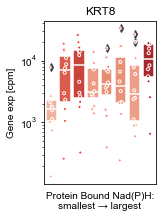

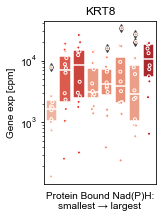

In [33]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea in feas:
    pos = corr.loc[high_pct].nlargest(3, fea).index

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

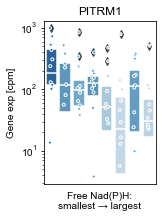

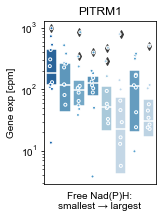

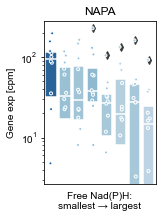

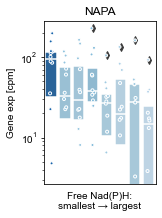

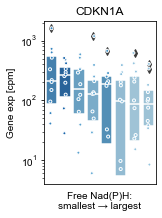

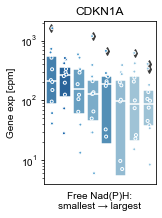

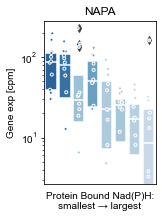

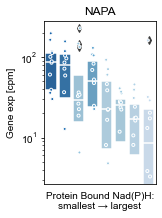

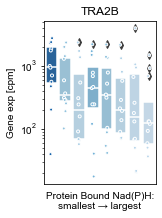

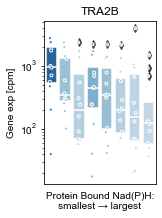

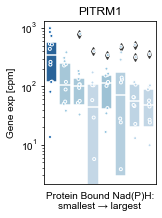

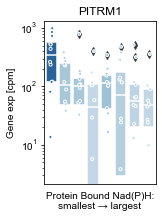

In [34]:
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']

for fea in feas:
    negs = corr.loc[high_pct].nsmallest(3, fea).index

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


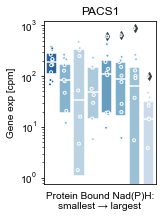

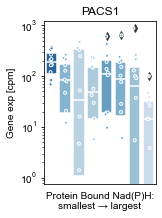

In [37]:
feas = ['Protein bound NAD(P)H']

for fea in feas:
    negs = ['PACS1']

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

### paper

In [13]:
def cum_number_corr(corr, fea):
    fig, ax = plt.subplots(figsize=[4, 3], dpi=100)
    for i in range(0, 10):
        n1 = 1 + i * 10
        if i < 9:
            n2 = n1 + 10
        else:
            n2 = 96

        Rs = corr[corr['Number'].isin(range(n1, n2))][fea].tolist()
        x = list(np.sort(Rs))
        y = list(1.0 - np.linspace(0, 1, len(Rs)))

    #     x = [min(Rs)] + x
    #     y = [0] + y

        ax.scatter(x, y, label='{}-{}'.format(str(n1), str(n2-1)), s=0.5, alpha=0.5)
    ax.legend(title='    # cells\nexpress genes', bbox_to_anchor=(1.02, 1.2), loc='upper left')
    ax.axvline(0, ls='--', c='k', zorder=-5, lw=0.5)
    ax.axhline(0.5, ls='--', c='k', zorder=-5, lw=0.5)

    ax.set_xlabel(r'$\rho$ [{} vs gene exp]'.format('area'))
    ax.set_ylabel('Cumulative over genes')
    
    return {'fig': fig, 'ax': ax}

{'fig': <Figure size 400x300 with 1 Axes>,
 'ax': <AxesSubplot: xlabel='$\\rho$ [area vs gene exp]', ylabel='Cumulative over genes'>}

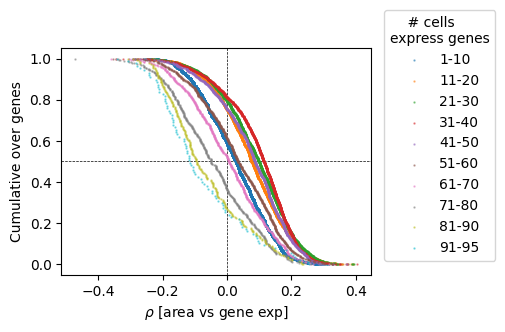

In [14]:
fea = 'Protein bound NAD(P)H'
cum_number_corr(corr, fea)

{'fig': <Figure size 400x300 with 1 Axes>,
 'ax': <AxesSubplot: xlabel='$\\rho$ [area vs gene exp]', ylabel='Cumulative over genes'>}

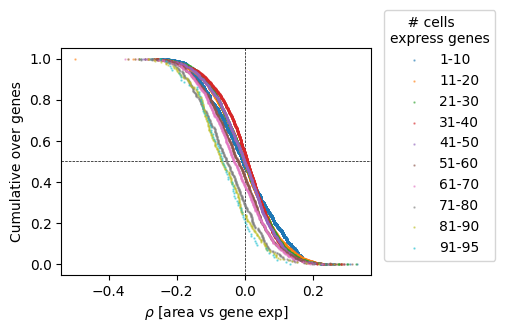

In [16]:
fea = 'Free NAD(P)H'
cum_number_corr(corr, fea)

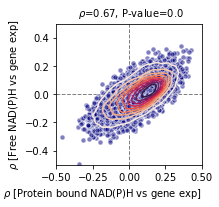

In [12]:
df = corr[corr['Number'] > 10]

fig, ax = plt.subplots(figsize=[3, 3])

ax.scatter(df['Protein bound NAD(P)H'], df['Free NAD(P)H'], color='navy', edgecolor='white', 
           alpha=0.5, s=25)
sns.kdeplot(data=df, x='Protein bound NAD(P)H', y='Free NAD(P)H', cmap='rocket_r', ax=ax)
ax.set_xlabel(r'$\rho$ [Protein bound NAD(P)H vs gene exp]', loc='right')
ax.set_ylabel(r'$\rho$ [Free NAD(P)H vs gene exp]')

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

from scipy.stats import spearmanr, pearsonr
rho, p = pearsonr(df['Protein bound NAD(P)H'], df['Free NAD(P)H'])
ax.text(-0.35, 0.55, r'$\rho$={}, P-value={}'.format(str(round(rho, 2)), str(round(p, 2))))

ax.axhline(0, c='gray', ls='--', lw=1, zorder=-5)
ax.axvline(0, c='gray', ls='--', lw=1, zorder=-5)

fig.tight_layout()
fig.savefig(save_figures + 'scatter.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'scatter.png', dpi=150, bbox_inches='tight')

In [87]:
fn_int='/home/yike/phd/dengue/data/interaction_source_file/inters_YK_20220324.tsv'
interactions = pd.read_csv(fn_int, sep='\t', dtype={'is_stimulation': 'object',
                                             'is_inhibition': 'object',
                                             'consensus_direction': 'object',
                                             'consensus_stimulation': 'object',
                                             'consensus_inhibition': 'object',
                                             'database_intercell_source': 'object',
                                             'transmitter_intercell_source': 'object',
                                             'receiver_intercell_source': 'object',
                                             'secreted_intercell_source': 'object',
                                             'plasma_membrane_transmembrane_intercell_source': 'object',
                                             'plasma_membrane_peripheral_intercell_source': 'object',
                                             'database_intercell_target': 'object',
                                             'transmitter_intercell_target': 'object',
                                             'receiver_intercell_target': 'object',
                                             'secreted_intercell_target': 'object',
                                             'plasma_membrane_transmembrane_intercell_target': 'object',
                                             'plasma_membrane_peripheral_intercell_target': 'object'})[['genesymbol_intercell_target', 'genesymbol_intercell_source']]

In [88]:
pos50 = df.sort_values('Protein bound NAD(P)H', ascending=False)[:50].index
neg50 = df.sort_values('Protein bound NAD(P)H', ascending=False)[-50:].index

In [97]:
a = interactions[
    interactions['genesymbol_intercell_target'].isin(pos50) |
    interactions['genesymbol_intercell_source'].isin(pos50)
]
a[~ a.duplicated()]
# CAP1: 
# RTN4: 
# MTDH: Promotes lung metastasis and also has an effect on bone and brain metastasis, possibly by enhancing the seeding of tumor cells to the target organ endothelium
# LGALS8: widely expressed in tumoral tissues and seems to be involved in integrin-like cell interactions

,genesymbol_intercell_target,genesymbol_intercell_source
3795,CNTNAP1,RTN4
5236,DCC,DSCAM
14922,GJB2,RTN4
21195,NGFR,RTN4
27439,MTDH,EGF
30680,ITGA3,LGALS8
35456,LINGO1,RTN4
35462,TNFRSF19,RTN4
35463,RTN4R,RTN4
35472,RTN4RL1,RTN4


In [101]:
b = interactions[
    interactions['genesymbol_intercell_target'].isin(neg50) |
    interactions['genesymbol_intercell_source'].isin(neg50)
]
b[~ b.duplicated()]

# HSP90AA1: Undergoes a functional cycle that is linked to its ATPase activity which is essential for its 
            # chaperone activity
# COPA: In eukaryotic cells, protein transport between the endoplasmic reticulum and Golgi compartments 
            # is mediated in part by non-clathrin-coated vesicular coat proteins (COPs)
# ST14: The protein encoded by this gene is an epithelial-derived, integral membrane serine protease.

,genesymbol_intercell_target,genesymbol_intercell_source
11219,HSP90AA1,EGFR
11220,HSP90AA1,ERBB2
11221,HSP90AA1,IFNG
11222,HSP90AA1,IL2
11223,HSP90AA1,KDR
11224,HSP90AA1,VTN
18415,NTRK1,COPA
19456,PLAU,ST14
21184,CD74,COPA
27699,MTNR1B,COPA


In [108]:
# PITRM1: The protein encoded by this gene is an ATP-dependent 
        # metalloprotease that degrades post-cleavage mitochondrial transit peptides
# DSCAM: This gene is a member of the immunoglobulin superfamily of cell adhesion molecules (Ig-CAMs)
# GPD2: catalyzes the conversion of glycerol-3-phosphate to dihydroxyacetone phosphate, using FAD as a cofactor
        # GDP1 & GDP2 reoxidizes NADH formed during glycolysis
# PPM1H: protein dephosphorylation
# RHOBTB3: Rab9-regulated ATPase required for endosome to Golgi transport.
# TSC22D2: RNA polymerase II
# BRAT1: The protein encoded by this ubiquitously expressed gene interacts with the tumor suppressing BRCA1 (breast cancer 1) protein 
        # and the ATM (ataxia telangiectasia mutated) protein.
# CD44: tumor metastasis
# CDKN1A: mediated inhibition of cellular proliferation in response to DNA damage
# CASC4: The increased expression level of this gene is associated with HER-2/neu proto-oncogene overexpression
    # Amplification and resulting overexpression of this proto-oncogene are found in approximately 30% of human breast and 20% of human ovarian cancers.
# AMIGO2: negative regulation of programmed cell death, cell-cell adhesion
df['r'] = np.sqrt(df['Free NAD(P)H'] ** 2 + df['Protein bound NAD(P)H'] ** 2)
df.sort_values('r')[-50:]

,Free NAD(P)H,Protein bound NAD(P)H,Frac,Number,ellipse,r
gene_name,,,,,,
BAZ2A,-0.121922,-0.304767,78.947368,75,navy,0.328250
Metazoa_SRP-128,-0.179961,-0.275032,90.526316,86,navy,0.328676
RPN1,-0.186996,-0.271062,95.789474,91,navy,0.329305
TAGLN2,-0.230088,-0.237161,89.473684,85,purple,0.330433
CSE1L,-0.178434,-0.280661,90.526316,86,navy,0.332580
FAM102B,0.211547,0.258592,55.789474,53,orange,0.334099
ANAPC1,-0.160468,-0.293390,90.526316,86,navy,0.334407
ASAP1,-0.263542,-0.206284,63.157895,60,purple,0.334675
RPS9,0.140557,0.303776,58.947368,56,orange,0.334718


In [113]:
'''
specific to protein bound NAD(P)H
'''
df[(abs(df['Free NAD(P)H']) < 0.05) &
   (abs(df['Protein bound NAD(P)H']) > 0.2) & (df['Number'] > 60)
  ].sort_values('Free NAD(P)H')

# ACAP2: enables activator activity
# BCAS3: participates in the regulation of cell polarity and directional endothelial cell migration, 
        # breast cancer marker
# PLK2: cell division

,Free NAD(P)H,Protein bound NAD(P)H,Frac,Number,ellipse,r
gene_name,,,,,,
ACAP2,-0.046398,-0.235045,70.526316,67,gray,0.239581
PDXK,-0.040028,0.223467,74.736842,71,gray,0.227024
ATN1,-0.036018,-0.232017,70.526316,67,gray,0.234796
DSCAM-AS1,-0.007167,0.210282,97.894737,93,gray,0.210404
BCAS3,0.003964,0.236871,88.421053,84,gray,0.236904
PLK2,0.024892,0.266797,66.315789,63,gray,0.267955
ACTG1,0.027591,0.225477,95.789474,91,gray,0.227159
LRP8,0.048765,-0.205943,75.789474,72,gray,0.211638


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

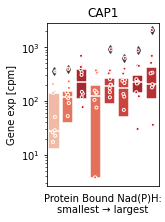

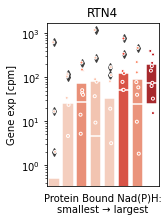

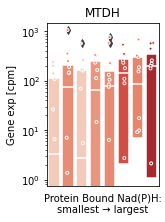

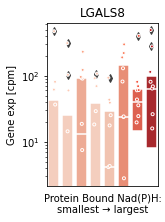

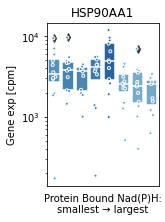

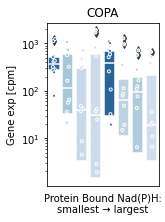

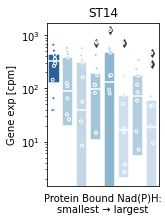

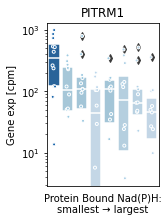

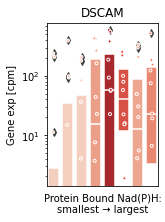

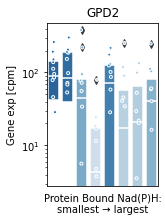

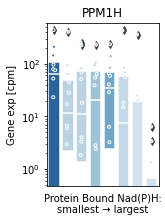

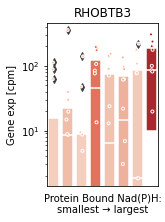

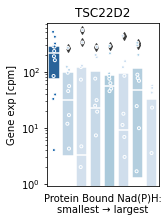

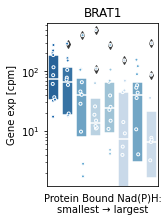

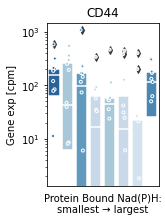

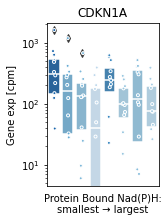

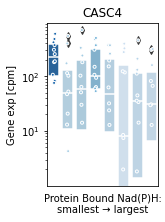

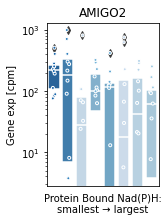

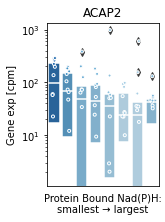

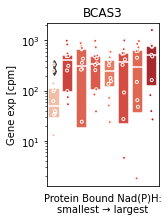

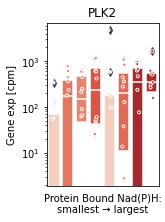

In [146]:
gene_list = [
    'CAP1', 'RTN4', 'MTDH', 'LGALS8',
    'HSP90AA1', 'COPA', 'ST14',
    'PITRM1', 'DSCAM', 'GPD2', 'PPM1H', 'RHOBTB3', 'TSC22D2',
    'BRAT1', 'CD44', 'CDKN1A', 'CASC4', 'AMIGO2',
    'ACAP2', 'BCAS3', 'PLK2'
]

fea = 'Protein bound NAD(P)H'
for gene in gene_list:
    if df.loc[gene]['Protein bound NAD(P)H'] > 0:
        cmap = 'Reds'
    else:
        cmap = 'Blues'
        
    bin_n = 8
    path = save_figures + 'paper/'

    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)